In [34]:
# ==============================================================
# 2D Heat Equation: PINN vs Pure NN vs Finite Difference
# ==============================================================
# u_t = alpha (u_xx + u_yy)
# Domain: x,y in [0,1], t in [0,1]
# IC: u(x,y,0)=sin(pi*x)*sin(pi*y)
# BC: u=0 on boundary
# ==============================================================

import torch, torch.nn as nn, torch.autograd as autograd
import numpy as np, matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
    "mathtext.fontset": "cm",
    "axes.unicode_minus": False,
    "text.latex.preamble": r"\usepackage{amsmath}",  # <-- add this
})
# --------------------------------------------------------------
# 0. Device setup (CUDA / MPS / CPU)
# --------------------------------------------------------------
if torch.cuda.is_available():
    device = torch.device("cuda"); print("⚡ Using CUDA GPU")
elif torch.backends.mps.is_available():
    device = torch.device("mps"); print("🍏 Using Apple Metal (MPS)")
else:
    device = torch.device("cpu"); print("💻 Using CPU")

# --------------------------------------------------------------
# 1. PDE parameters & analytical reference
# --------------------------------------------------------------
alpha = 0.01
def analytic_solution(x, y, t):
    return np.exp(-2*np.pi**2*alpha*t) * np.sin(np.pi*x) * np.sin(np.pi*y)

# --------------------------------------------------------------
# 2. Finite Difference reference solution
# --------------------------------------------------------------
nx=ny=41; nt=200
xv=np.linspace(0,1,nx); yv=np.linspace(0,1,ny); tv=np.linspace(0,1,nt)
X,Y=np.meshgrid(xv,yv)
dx=1/(nx-1); dy=1/(ny-1); dt=tv[1]-tv[0]
U=np.zeros((nt,ny,nx))
U[0]=np.sin(np.pi*X)*np.sin(np.pi*Y)
r=alpha*dt/dx**2
for n in range(0,nt-1):
    U[n+1,1:-1,1:-1] = (U[n,1:-1,1:-1] +
                        r*(U[n,1:-1,2:]-2*U[n,1:-1,1:-1]+U[n,1:-1,0:-2]) +
                        r*(U[n,2:,1:-1]-2*U[n,1:-1,1:-1]+U[n,0:-2,1:-1]))
print("✅ Finite Difference reference computed")

# --------------------------------------------------------------
# 3. Sample training data from FD (for NN)
# --------------------------------------------------------------
n_samples = 20
x_data = np.random.rand(n_samples,1)
y_data = np.random.rand(n_samples,1)
t_data = np.random.rand(n_samples,1)
u_data = analytic_solution(x_data, y_data, t_data)  # or sample from U interpolation

# Convert to tensors
def to_torch(a): return torch.tensor(a, dtype=torch.float32, device=device)
x_d, y_d, t_d, u_d = map(to_torch, (x_data, y_data, t_data, u_data))

# --------------------------------------------------------------
# 4. Define shared NN architecture
# --------------------------------------------------------------
class HeatNN(nn.Module):
    def __init__(self, layers=(3,64,64,64,64,1)):
        super().__init__()
        net=[]
        for i in range(len(layers)-2):
            net += [nn.Linear(layers[i], layers[i+1]), nn.Tanh()]
        net += [nn.Linear(layers[-2], layers[-1])]
        self.net = nn.Sequential(*net)
    def forward(self, x, y, t):
        return self.net(torch.cat([x,y,t], dim=1))

# --------------------------------------------------------------
# 5. Train the PURE Neural Network (data-driven only)
# --------------------------------------------------------------
nn_model = HeatNN().to(device)
opt_nn = torch.optim.Adam(nn_model.parameters(), lr=1e-3)

for epoch in range(5000):
    opt_nn.zero_grad(set_to_none=True)
    u_pred = nn_model(x_d, y_d, t_d)
    loss = ((u_pred - u_d)**2).mean()
    loss.backward()
    opt_nn.step()
    if epoch % 500 == 0:
        print(f"[NN] Epoch {epoch:4d} | Data Loss={loss.item():.3e}")

# --------------------------------------------------------------
# 6. Train the Physics-Informed Neural Network (PINN)
# --------------------------------------------------------------
# Collocation, boundary, and initial condition points
N_f, N_b, N_i = 20000, 2000, 2000

x_f = np.random.rand(N_f,1)
y_f = np.random.rand(N_f,1)
t_f = np.random.rand(N_f,1)

xb = np.random.rand(N_b,1)
yb = np.random.rand(N_b,1)
tb = np.random.rand(N_b,1)
face = np.random.randint(0,4,N_b)
x_b, y_b = xb.copy(), yb.copy()
x_b[face==0] = 0; x_b[face==1] = 1
y_b[face==2] = 0; y_b[face==3] = 1

x_i = np.random.rand(N_i,1)
y_i = np.random.rand(N_i,1)
t_i = np.zeros((N_i,1))
u_i = np.sin(np.pi*x_i)*np.sin(np.pi*y_i)

x_f, y_f, t_f = map(to_torch, (x_f, y_f, t_f))
x_b, y_b, t_b = map(to_torch, (x_b, y_b, tb))
x_i, y_i, t_i, u_i = map(to_torch, (x_i, y_i, t_i, u_i))

for T in [x_f,y_f,t_f,x_b,y_b,t_b,x_i,y_i,t_i]:
    T.requires_grad_(True)

# Define PDE residual
def pde_residual(model, x, y, t):
    u = model(x,y,t)
    grads = autograd.grad(u, [x,y,t],
                          grad_outputs=torch.ones_like(u),
                          create_graph=True, retain_graph=True)
    u_x, u_y, u_t = grads
    u_xx = autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True, retain_graph=True)[0]
    u_yy = autograd.grad(u_y, y, torch.ones_like(u_y), create_graph=True, retain_graph=True)[0]
    return u_t - alpha*(u_xx + u_yy)

# Train PINN
pinn_model = HeatNN().to(device)
opt_pinn = torch.optim.Adam(pinn_model.parameters(), lr=1e-3)

for epoch in range(5000):
    opt_pinn.zero_grad(set_to_none=True)
    f_res = pde_residual(pinn_model, x_f, y_f, t_f)
    loss_f = (f_res**2).mean()
    u_b = pinn_model(x_b, y_b, t_b)
    loss_b = (u_b**2).mean()
    u_pred_i = pinn_model(x_i, y_i, t_i)
    loss_i = ((u_pred_i - u_i)**2).mean()
    loss = loss_f + loss_b + loss_i
    loss.backward(retain_graph=True)
    opt_pinn.step()
    if epoch % 500 == 0:
        print(f"[PINN] Epoch {epoch:4d} | Total Loss={loss.item():.3e} | PDE={loss_f.item():.3e}")

# --------------------------------------------------------------
# 7. Evaluate all models at t=0.5
# --------------------------------------------------------------
xg=torch.tensor(X.flatten(),dtype=torch.float32,device=device).view(-1,1)
yg=torch.tensor(Y.flatten(),dtype=torch.float32,device=device).view(-1,1)
time_idx = int(0.5*(nt-1))
tg=torch.full_like(xg, tv[time_idx])

with torch.no_grad():
    u_pinn = pinn_model(xg, yg, tg).cpu().numpy().reshape(ny,nx)
    u_nn = nn_model(xg, yg, tg).cpu().numpy().reshape(ny,nx)
U_true = U[time_idx]

# --------------------------------------------------------------
# 8. Visualization: NN vs PINN vs FD (consistent color scales)
# --------------------------------------------------------------
from matplotlib import animation
from IPython.display import HTML

# Determine common limits
u_min = min(U_true.min(), u_nn.min(), u_pinn.min())
u_max = max(U_true.max(), u_nn.max(), u_pinn.max())
err_nn = abs(U_true - u_nn)
err_pinn = abs(U_true - u_pinn)
err_min = 0.0
err_max = max(err_nn.max(), err_pinn.max())

⚡ Using CUDA GPU
✅ Finite Difference reference computed
[NN] Epoch    0 | Data Loss=2.612e-01
[NN] Epoch  500 | Data Loss=2.000e-04
[NN] Epoch 1000 | Data Loss=7.064e-06
[NN] Epoch 1500 | Data Loss=1.257e-05
[NN] Epoch 2000 | Data Loss=2.559e-06
[NN] Epoch 2500 | Data Loss=1.644e-06
[NN] Epoch 3000 | Data Loss=2.194e-05
[NN] Epoch 3500 | Data Loss=8.466e-07
[NN] Epoch 4000 | Data Loss=4.842e-07
[NN] Epoch 4500 | Data Loss=3.668e-07
[PINN] Epoch    0 | Total Loss=1.801e-01 | PDE=3.384e-04
[PINN] Epoch  500 | Total Loss=3.091e-03 | PDE=9.468e-04
[PINN] Epoch 1000 | Total Loss=1.680e-03 | PDE=7.176e-04
[PINN] Epoch 1500 | Total Loss=7.428e-04 | PDE=3.619e-04
[PINN] Epoch 2000 | Total Loss=4.516e-04 | PDE=2.075e-04
[PINN] Epoch 2500 | Total Loss=2.800e-04 | PDE=1.330e-04
[PINN] Epoch 3000 | Total Loss=2.005e-04 | PDE=1.019e-04
[PINN] Epoch 3500 | Total Loss=1.594e-04 | PDE=8.534e-05
[PINN] Epoch 4000 | Total Loss=6.722e-04 | PDE=1.008e-04
[PINN] Epoch 4500 | Total Loss=1.193e-04 | PDE=6.52

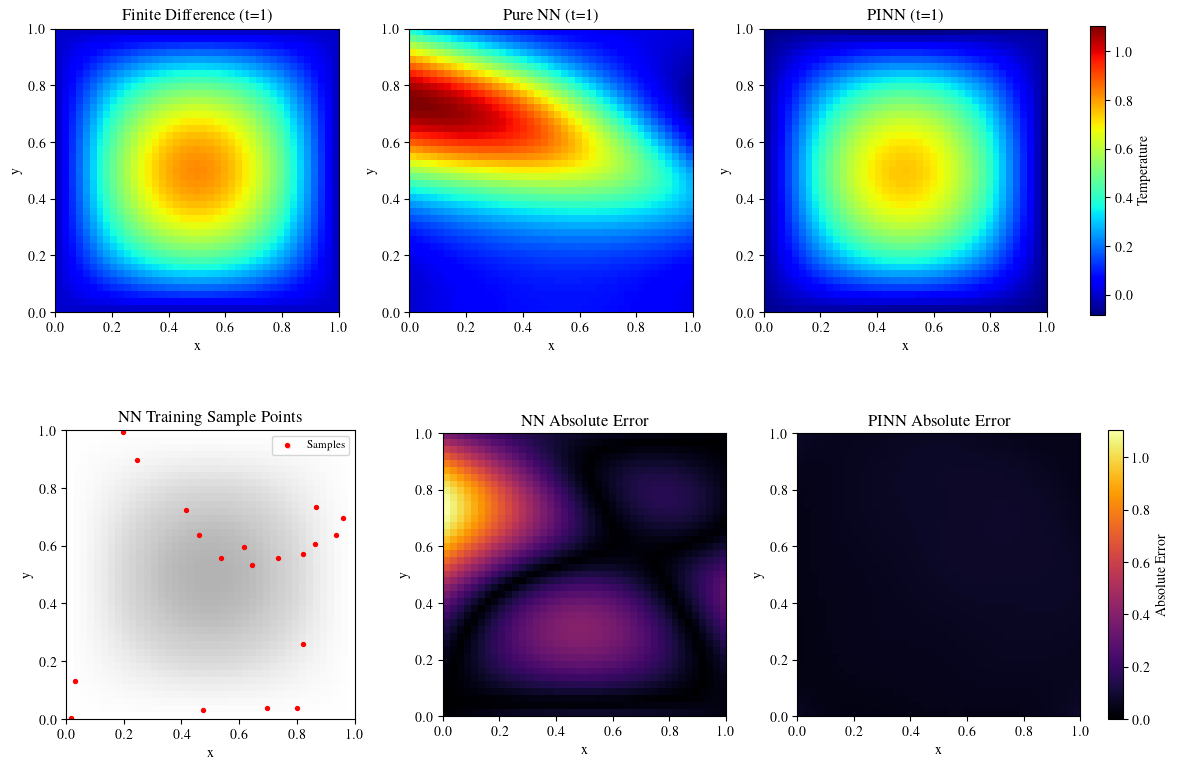

In [35]:
# ==============================================================
# 8. STATIC COMPARISON: FD, NN, PINN, Errors, and Sample Points
# ==============================================================

import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# Select a snapshot time index
time_idx = int(0.5 * (nt - 1))  # mid-time t=0.5
time_idx = int(nt -1) 
U_true = U[time_idx]

# Predict NN and PINN at same time
tg = torch.full_like(xg, tv[time_idx])
with torch.no_grad():
    u_nn = nn_model(xg, yg, tg).cpu().numpy().reshape(ny, nx)
    u_pinn = pinn_model(xg, yg, tg).cpu().numpy().reshape(ny, nx)

# ---------------- Common color scales ----------------
u_min = min(U_true.min(), u_nn.min(), u_pinn.min())
u_max = max(U_true.max(), u_nn.max(), u_pinn.max())

err_nn = abs(U_true - u_nn)
err_pinn = abs(U_true - u_pinn)
err_min, err_max = 0.0, max(err_nn.max(), err_pinn.max())

# -----------------------------------------------------
# Plot 2x3 grid: FD | NN | PINN  /  Sample | NN Err | PINN Err
# -----------------------------------------------------
fig, axes = plt.subplots(2, 3, figsize=(14, 9))
(ax_fd, ax_nn, ax_pinn), (ax_samples, ax_nne, ax_pinne) = axes

plt.subplots_adjust(hspace=0.4, wspace=0.25)  # add vertical + horizontal spacing

# --- Row 1: Solutions ---
im_fd = ax_fd.imshow(U_true, origin='lower', extent=[0,1,0,1],
                     cmap='jet', vmin=u_min, vmax=u_max)
ax_fd.set_title("Finite Difference (t=1)")
im_nn = ax_nn.imshow(u_nn, origin='lower', extent=[0,1,0,1],
                     cmap='jet', vmin=u_min, vmax=u_max)
ax_nn.set_title("Pure NN (t=1)")
im_pinn = ax_pinn.imshow(u_pinn, origin='lower', extent=[0,1,0,1],
                         cmap='jet', vmin=u_min, vmax=u_max)
ax_pinn.set_title("PINN (t=1)")

# Add one shared vertical colorbar for top row (on the right)
cbar_top = fig.colorbar(im_fd, ax=[ax_fd, ax_nn, ax_pinn],
                        orientation='vertical', fraction=0.046, pad=0.04)
cbar_top.set_label("Temperature")

# --- Row 2, Col 1: Sample point locations ---
ax_samples.set_title("NN Training Sample Points")
ax_samples.imshow(U_true, origin='lower', extent=[0,1,0,1],
                  cmap='Greys', alpha=0.3)
ax_samples.scatter(x_data, y_data, s=8, c='red', label='Samples')
ax_samples.set_xlim([0,1]); ax_samples.set_ylim([0,1])
ax_samples.legend(loc='upper right', fontsize=8)

# --- Row 2, Col 2: NN Error ---
im_nne = ax_nne.imshow(err_nn, origin='lower', extent=[0,1,0,1],
                       cmap='inferno', vmin=err_min, vmax=err_max)
ax_nne.set_title("NN Absolute Error")

# --- Row 2, Col 3: PINN Error ---
im_pinne = ax_pinne.imshow(err_pinn, origin='lower', extent=[0,1,0,1],
                           cmap='inferno', vmin=err_min, vmax=err_max)
ax_pinne.set_title("PINN Absolute Error")

# Shared vertical colorbar for error plots (on the right)
cbar_bottom = fig.colorbar(im_nne, ax=[ax_nne, ax_pinne],
                           orientation='vertical', fraction=0.046, pad=0.04)
cbar_bottom.set_label("Absolute Error")

for ax in axes.ravel():
    ax.set_xlabel("x")
    ax.set_ylabel("y")

plt.show()


In [36]:
# ==============================================================
# 9. ANIMATION: Time Evolution (FD | NN | PINN)
# ==============================================================

print("🎞️ Creating 3-panel animation (FD | NN | PINN)...")

fig, axes = plt.subplots(1, 3, figsize=(13, 4))
ax1, ax2, ax3 = axes
fig.suptitle("Time Evolution: Finite Difference vs NN vs PINN", fontsize=14)

# Common color scale for all
u_min_anim = u_min
u_max_anim = u_max

# Initialize images
im1 = ax1.imshow(U[0], extent=[0,1,0,1], origin='lower', cmap='jet',
                 vmin=u_min_anim, vmax=u_max_anim, animated=True)
im2 = ax2.imshow(U[0], extent=[0,1,0,1], origin='lower', cmap='jet',
                 vmin=u_min_anim, vmax=u_max_anim, animated=True)
im3 = ax3.imshow(U[0], extent=[0,1,0,1], origin='lower', cmap='jet',
                 vmin=u_min_anim, vmax=u_max_anim, animated=True)

for ax, title in zip(axes, ["Finite Difference", "Pure NN", "PINN"]):
    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

fig.colorbar(im1, ax=axes.ravel().tolist(), shrink=0.8, label="Temperature")

# Animation update function
def animate(i):
    tg = torch.full_like(xg, tv[i])
    with torch.no_grad():
        u_nn_frame = nn_model(xg, yg, tg).cpu().numpy().reshape(ny, nx)
        u_pinn_frame = pinn_model(xg, yg, tg).cpu().numpy().reshape(ny, nx)
    im1.set_array(U[i])
    im2.set_array(u_nn_frame)
    im3.set_array(u_pinn_frame)
    ax1.set_title(f"FD (t={tv[i]:.2f})")
    ax2.set_title(f"NN (t={tv[i]:.2f})")
    ax3.set_title(f"PINN (t={tv[i]:.2f})")
    return [im1, im2, im3]

anim = animation.FuncAnimation(fig, animate, frames=nt, interval=80, blit=True)
plt.close(fig)

# Display animation inline
HTML(anim.to_jshtml())


🎞️ Creating 3-panel animation (FD | NN | PINN)...
